# <center> **ПРОЕКТ: Кластеризация изображений транспортных средств**
# ЧАСТЬ 1. Обработка данных и создание модели

## Установка необходимых комплектующих

Чтобы решить любой из кейсов, требуется работать с большими объёмами данных. По мере увеличения объёма данных алгоритмы, работающие на процессоре (CPU), становятся медленными и громоздкими. Для оптимизации вычислений и экономии времени мы воспользуемся инструментом RAPIDS.

**RAPIDS** — бесплатный open-source фреймворк для ускорения обработки данных. Он предоставляет упрощённый подход, при котором данные изначально загружаются в графический процессор (GPU), и вычислительные задачи могут выполняться на нём напрямую. RAPIDS предоставляет аналоги библиотек для работы с данными, приведенные ниже:

* **cupy** - *numpy*
* **cuDF** - *pandas*
* **cuML** - *sklearn*

Их я и буду использовать.

In [1]:
!nvidia-smi

Fri Apr 18 09:06:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
error: a value is required for '--prerelease <PRERELEASE>' but none was supplied
  [possible values: disallow, allow, if-necessary, explicit, if-necessary-or-explicit]

For more information, try '--help'.

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://gith

In [3]:
!pip install optuna

## Импорт данных

Данные хранятся у меня на диске, так что я загружаю их из него.

In [4]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Импорт библиотек

In [5]:
# набор инструментов от RAPIDS
import cupy
import cudf

from cuml.cluster import KMeans
from cuml.decomposition import PCA
from cuml.pipeline import Pipeline

import cuml.common.device_selection as ds

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# оптимизация
from optuna import create_study

# технические моменты
import warnings
import pickle
import os

from IPython.display import display

# настройка параметров ноутбука
ds.set_global_device_type("GPU")
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

RS = 12 # random_state

## Стратегия

У нас есть 4 разных датасета и всех их нужно обработать. Если это делать одновременно, например в одной ячейке, то это оказывает очень большую нагрузку на оперативную память, так как они довольно большие. Поэтому я буду обрабатывать каждый из них по отдельности и каждому выделить свой раздел ноутбука. Поэтому я решил составить единый план действий для каждого из датасетов, состоять он будет из следующих пунктов:

1. **Знакомство со структурой данных**\
Каждая строка из numpy-матрицы, хранящейся в файле `.pickle`, является дескриптором соответствующего изображения. Признаки, найденные с помощью некоторых моделей, могут исчисляться тысячами.

2. **Преобразование, очистка и анализ данных**\
 Производить кластеризацию на слишком большом количестве признаков, довольно сложно и затратно по времени. Можно стандартизировать данные и уменьшить их размерность до 100-200 признаков.  

3. **Моделирование и оценка качества модели**\
Из библиотеки cuML я буду использовать 2 алгоритма кластеризации, соответственно к каждому из них должен быть свой подход:
  - *KMeans*\
  Этот алгоритм нужен мне именно для разделения данных на кластеры. Главный параметр данного алгоритма - `n_clusters`, количество кластеров. Наиболее разумным будет значение от 2 до 10.
  - *HDBSCAN*\
  С помощью этого алгоритма я буду выявлять выбросы в данных. Его главный параметр - минимальное количество точек, входящих в кластер, `min_cluster_size`.

  В качестве метрики для подбора оптимального количества кластеров я буду использовать внутренние меры:
  * индекс Калински-Харабаса (`calinski_harabasz_score`)
  * индекс Дэвиса-Болдина (`davies_bouldin_score`)

4. **Интерпретация кластеров и поиск выбросов**\
Этот этап будет проходить в другом ноутбуке, так как для этого потребуются оригинальные изображения и пути к ним. Для этого мне необходимо понизить размерность до двух признаков, сохранить каждый из результатов модели в отдельные файлы и сделать их визуализацию.

In [6]:
### 1. Знакомство со структурой данных

def pkl_load(f_path):
    desc_path = '/content/drive/MyDrive/descriptors/'

    return cupy.array(pickle.load(open(desc_path+f_path, 'rb')))

# ------------------------------------------------------------------------------

def print_data(data, name):
    print(f'{name}:\n{data[:5, :10]}')
    print(f'{data.shape[0]} rows, {data.shape[1]} columns')

# ------------------------------------------------------------------------------

def save_results(X, name, n_components, n_clusters):
    reductor = PCA(
        n_components=n_components,
        copy=False,
        verbose=0
    )

    X_red = reductor.fit_transform(X)

    clustering = KMeans(n_clusters=n_clusters, random_state=RS)
    y = clustering.fit_predict(X_red)

    X_tocsv = cudf.DataFrame(X_red).to_pandas()
    y_tocsv = cudf.Series(y).to_pandas()

    y_vc = y_tocsv.value_counts()
    y_vc.plot(kind='bar')
    plt.title(f'"y_{name}" clusters counts')
    plt.show()

    path = '/content/clusters'

    if not os.path.exists(path):
        os.mkdir(path)

    X_tocsv.to_csv(path+'/X_'+name+'.csv', index=False)
    y_tocsv.to_csv(path+'/y_'+name+'.csv', index=False)

# ------------------------------------------------------------------------------


### 2. Моделирование и оценка качества модели

def calinski_harabasz_score(X, labels) -> float:
    n_samples = X.shape[0]
    n_labels = len(cupy.unique(labels))

    extra_disp, intra_disp = 0.0, 0.0
    mean = cupy.mean(X, axis=0)

    for k in range(n_labels):
        cluster_k = X[labels == k]
        mean_k = cupy.mean(cluster_k, axis=0)

        extra_disp += len(cluster_k) * cupy.sum((mean_k - mean)**2)
        intra_disp += cupy.sum((cluster_k - mean_k)**2)

    score = (
        extra_disp *
        (n_samples-n_labels) /
        (intra_disp * (n_labels-1.0))
    )

    return 1.0 if intra_disp == 0.0 else score

# ------------------------------------------------------------------------------

def calc_score(X, n_components, n_clusters):
    #cupy.random.seed(RS)
    #idx = cupy.random.randint(X.shape[0], size=100000)

    reductor = PCA(
        n_components=n_components,
        copy=False,
        verbose=0
    )

    X_red = reductor.fit_transform(X)

    clustering = KMeans(n_clusters=n_clusters, random_state=RS)
    y = clustering.fit_predict(X_red)

    score = calinski_harabasz_score(X_red, y)

    return score

# ------------------------------------------------------------------------------


### 3. Подбор числа главных компонент и кластеров

def opt_params_tuna(X, name):
    cupy.random.seed(RS)
    idx = cupy.random.randint(X.shape[0], size=100000)

    max_comp = X.shape[1] // 2

    def opt_params(trial):
        n_components = trial.suggest_int('n_components', 10, max_comp)
        n_clusters = trial.suggest_int('n_clusters', 2, 10)

        score = calc_score(X, n_components, n_clusters)

        return score

    study = create_study(study_name=name, direction='maximize')
    study.optimize(opt_params, n_trials=50)

    print('')
    return study.best_params

# ------------------------------------------------------------------------------

def opt_params_grid(X, feature_bounds, cluster_bounds, name):
    n_cmps = list(range(feature_bounds[0], feature_bounds[1]+1))
    n_clts = list(range(cluster_bounds[0], cluster_bounds[1]+1))
    cnt = 0

    scores = cudf.DataFrame(
        index=list(range(len(n_cmps)*len(n_clts))),
        columns=['n_components', 'n_clusters', 'score']
    )

    for a in n_cmps:
        for b in n_clts:
            scores.loc[cnt, 'n_components'] = a
            scores.loc[cnt, 'n_clusters'] = b

            score = calc_score(X, a, b)
            scores.loc[cnt, 'score'] = score.round(2)

            cnt += 1

    plt.figure(figsize=(10, 10))
    sns.lineplot(
        scores.to_pandas(),
        x='n_components',
        y='score',
        hue='n_clusters'
    )

    plt.title(f"{name}'s CH score per number of components and clusters")
    plt.show()

    best_params = scores.sort_values(
        'score',
        ascending=False
        ).loc[0].to_dict()

    return best_params

# ------------------------------------------------------------------------------

# **EFFICIENTNET**

In [7]:
X_effnet = pkl_load('efficientnet-b7.pickle')
effnet_name = 'EfficientNet'

print_data(X_effnet, effnet_name)

EfficientNet:
[[ 0.07503103  0.31044954  0.27607426 -0.09375478 -0.03092266  0.05304439
  -0.09984544  0.0234847   0.07960403 -0.14443047]
 [ 0.10779837 -0.09006837  0.46310857  0.05093966  0.60092247  0.08299492
   0.14803526 -0.15697914 -0.12493151 -0.08069657]
 [ 0.13423096  0.05216528 -0.06171756 -0.01218371 -0.04603375  0.40719098
   0.17643325  0.14494173  0.3118309   0.19962694]
 [ 0.02804002  0.25177845 -0.13154922 -0.14530808  0.3491551  -0.02400591
  -0.06593723  0.30966318 -0.16115531 -0.0865703 ]
 [ 0.14294054 -0.13410813  0.15225166  0.2971836  -0.20555295  0.03235854
   0.16065025 -0.1065819  -0.03586044  0.0146062 ]]
416314 rows, 2560 columns


In [8]:
opt_params_tuna(X_effnet, effnet_name)

[I 2025-04-18 09:07:30,293] A new study created in memory with name: EfficientNet
[I 2025-04-18 09:07:37,901] Trial 0 finished with value: 22712.10076032374 and parameters: {'n_components': 313, 'n_clusters': 3}. Best is trial 0 with value: 22712.10076032374.
[I 2025-04-18 09:07:43,632] Trial 1 finished with value: 31459.543048693427 and parameters: {'n_components': 448, 'n_clusters': 2}. Best is trial 1 with value: 31459.543048693427.
[I 2025-04-18 09:07:49,024] Trial 2 finished with value: 35370.49891938497 and parameters: {'n_components': 280, 'n_clusters': 2}. Best is trial 2 with value: 35370.49891938497.
[I 2025-04-18 09:07:59,298] Trial 3 finished with value: 6107.297131661498 and parameters: {'n_components': 977, 'n_clusters': 10}. Best is trial 2 with value: 35370.49891938497.
[I 2025-04-18 09:08:06,621] Trial 4 finished with value: 11220.906956770737 and parameters: {'n_components': 593, 'n_clusters': 5}. Best is trial 2 with value: 35370.49891938497.
[I 2025-04-18 09:08:12,1

{'n_components': 12, 'n_clusters': 2}

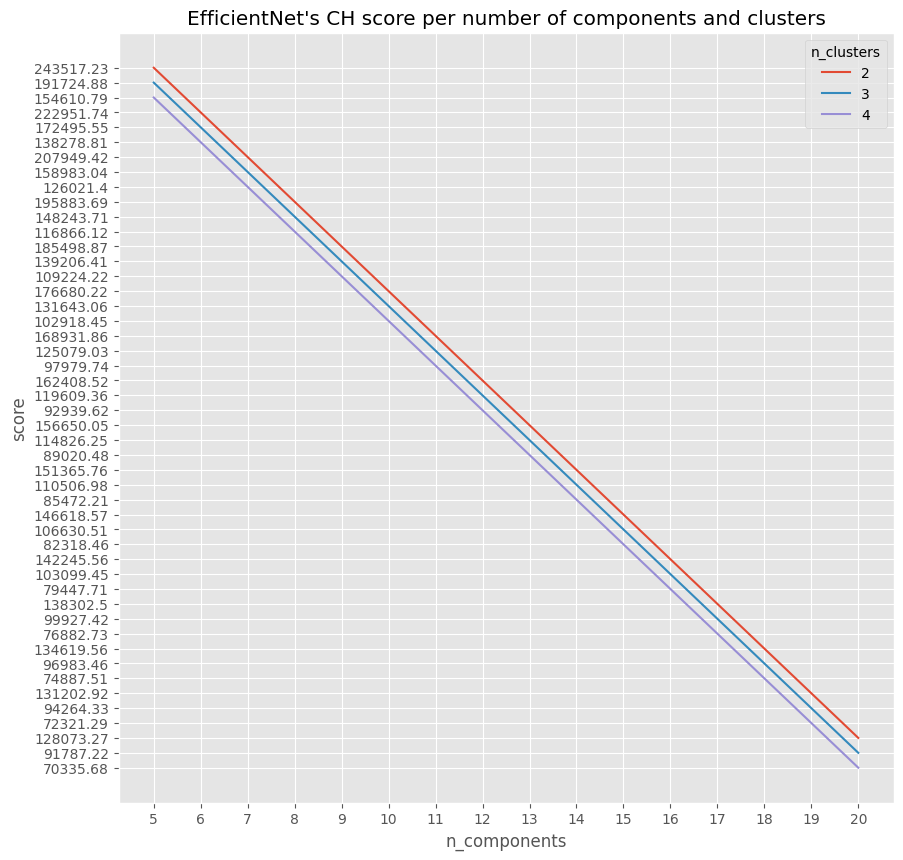

{'n_components': '5', 'n_clusters': '2', 'score': '243517.23'}

In [9]:
opt_params_grid(X_effnet, (5, 20), (2, 4), effnet_name)

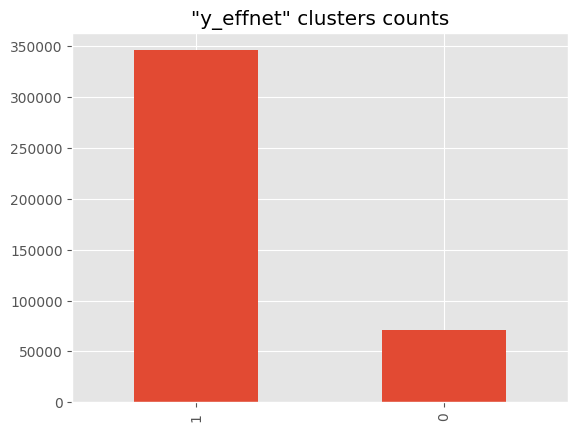

In [10]:
save_results(X_effnet, 'effnet', 5, 2)

# **OSNET**

In [11]:
X_osnet = pkl_load('osnet.pickle')
osnet_name = 'OSNet'

print_data(X_osnet, osnet_name)

OSNet:
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3329916e-40 1.2994150e+00
  4.4821372e+00 0.0000000e+00 0.0000000e+00 2.5215778e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3329916e-40 1.2090728e+00
  5.1453791e+00 0.0000000e+00 0.0000000e+00 2.7628396e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3329916e-40 8.6784363e-05
  1.8148808e+00 7.2372377e-01 0.0000000e+00 1.7984325e+00 3.0797836e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3329916e-40 1.0485553e+00
  3.8501453e+00 0.0000000e+00 0.0000000e+00 2.4508934e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3329916e-40 0.0000000e+00
  1.6277972e+00 1.0275152e+00 0.0000000e+00 2.3101077e+00 1.3547012e+00]]
416314 rows, 512 columns


In [12]:
opt_params_tuna(X_osnet, osnet_name)

[I 2025-04-18 09:17:07,756] A new study created in memory with name: OSNet
[I 2025-04-18 09:17:09,163] Trial 0 finished with value: 33131.43555428801 and parameters: {'n_components': 165, 'n_clusters': 6}. Best is trial 0 with value: 33131.43555428801.
[I 2025-04-18 09:17:10,085] Trial 1 finished with value: 43665.79616350503 and parameters: {'n_components': 51, 'n_clusters': 4}. Best is trial 1 with value: 43665.79616350503.
[I 2025-04-18 09:17:11,513] Trial 2 finished with value: 23762.030245286118 and parameters: {'n_components': 221, 'n_clusters': 10}. Best is trial 1 with value: 43665.79616350503.
[I 2025-04-18 09:17:11,938] Trial 3 finished with value: 43803.88113924413 and parameters: {'n_components': 40, 'n_clusters': 5}. Best is trial 3 with value: 43803.88113924413.
[I 2025-04-18 09:17:13,179] Trial 4 finished with value: 26021.946293912562 and parameters: {'n_components': 168, 'n_clusters': 9}. Best is trial 3 with value: 43803.88113924413.
[I 2025-04-18 09:17:14,606] Trial 

{'n_components': 10, 'n_clusters': 2}

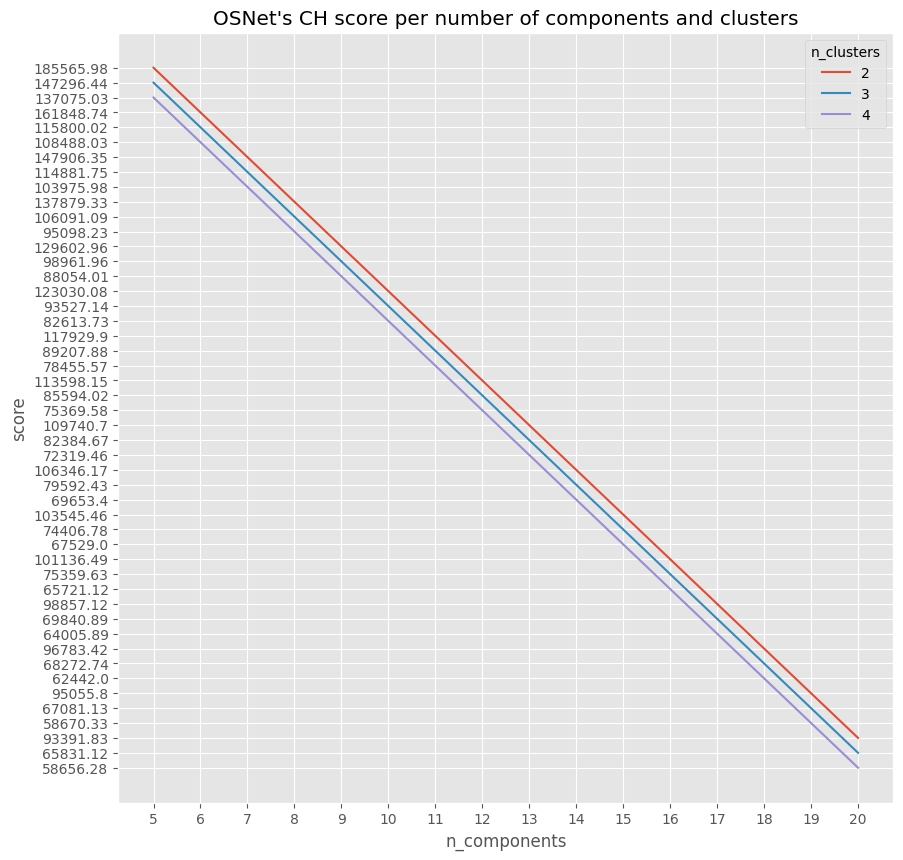

{'n_components': '5', 'n_clusters': '2', 'score': '185565.98'}

In [13]:
opt_params_grid(X_osnet, (5, 20), (2, 4), osnet_name)

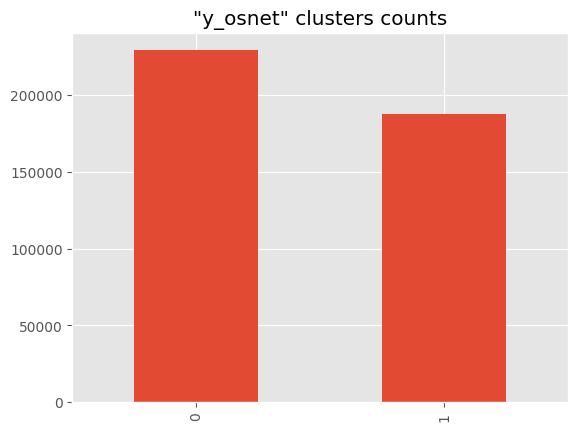

In [14]:
save_results(X_osnet, 'osnet', 5, 2)

# **VDC COLOR REGRESSION**

In [15]:
X_vdc_color = pkl_load('vdc_color.pickle')
vdc_color_name = 'VDC color regression'

print_data(X_vdc_color, vdc_color_name)

VDC color regression:
[[-0.9374271  -0.05472132  0.596811   -0.9179606  -0.29986545 -0.914162
  -0.51177955 -0.95856386 -0.5862114  -0.52473813]
 [-0.57900274  0.07446817  0.80651325 -1.0844814  -0.21445857 -1.2949836
  -0.62427616 -1.125337   -0.8629099  -0.818761  ]
 [-0.58707464 -0.48330888  0.7987211  -0.8116134  -0.37385893 -0.91399837
  -0.95796746 -1.0490061  -0.6939856  -0.6550549 ]
 [-0.87896514 -0.1271264   0.7801766  -0.88375586 -0.43294993 -1.1448781
  -0.70646495 -0.8676922  -0.66413176 -0.62670636]
 [-0.57456505 -0.5040994   0.895725   -0.6989022  -0.23598234 -0.9225721
  -0.6867517  -1.1816711  -1.0072246  -0.50882405]]
416314 rows, 128 columns


In [16]:
opt_params_tuna(X_vdc_color, vdc_color_name)

[I 2025-04-18 09:18:10,026] A new study created in memory with name: VDC color regression
[I 2025-04-18 09:18:10,334] Trial 0 finished with value: 159344.2826902851 and parameters: {'n_components': 11, 'n_clusters': 7}. Best is trial 0 with value: 159344.2826902851.
[I 2025-04-18 09:18:10,896] Trial 1 finished with value: 74259.88616497647 and parameters: {'n_components': 64, 'n_clusters': 9}. Best is trial 0 with value: 159344.2826902851.
[I 2025-04-18 09:18:11,575] Trial 2 finished with value: 124605.44810495648 and parameters: {'n_components': 52, 'n_clusters': 5}. Best is trial 0 with value: 159344.2826902851.
[I 2025-04-18 09:18:11,782] Trial 3 finished with value: 264134.8829034908 and parameters: {'n_components': 37, 'n_clusters': 2}. Best is trial 3 with value: 264134.8829034908.
[I 2025-04-18 09:18:12,073] Trial 4 finished with value: 131390.95876457056 and parameters: {'n_components': 28, 'n_clusters': 6}. Best is trial 3 with value: 264134.8829034908.
[I 2025-04-18 09:18:12,

{'n_components': 12, 'n_clusters': 2}

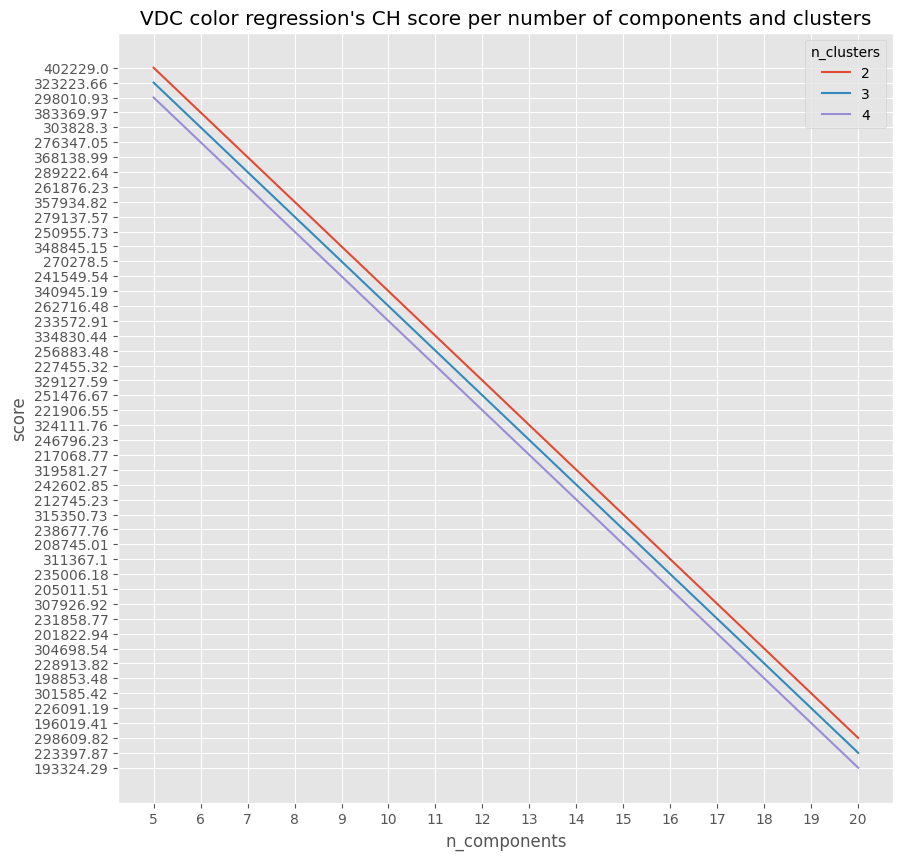

{'n_components': '5', 'n_clusters': '2', 'score': '402229.0'}

In [17]:
opt_params_grid(X_vdc_color, (5, 20), (2, 4), vdc_color_name)

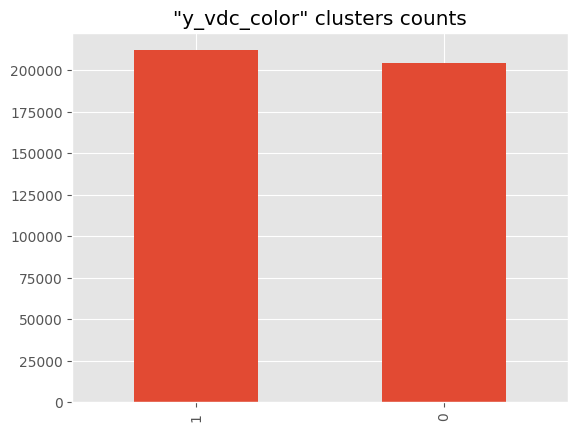

In [18]:
save_results(X_vdc_color, 'vdc_color', 5, 2)

# **VDC TYPE CLASSIFICATION**

In [19]:
X_vdc_type = pkl_load('vdc_type.pickle')
vdc_type_name = 'VDC type classification'

print_data(X_vdc_type, vdc_type_name)

VDC type classification:
[[0.02564181 0.00200849 0.14198549 0.23509574 0.30522653 0.5566322
  0.02597516 0.         0.28166044 0.02216517]
 [0.00805954 0.         0.13719751 0.2776476  0.11849266 0.1802693
  0.         0.06436481 0.45901057 0.02830551]
 [0.03058972 0.03774371 0.01926565 0.1089038  0.00459949 0.14313143
  0.03020552 0.0476797  0.22836952 0.00741766]
 [0.00434611 0.         0.13767008 0.29437226 0.3878197  0.54739547
  0.00617594 0.0123903  0.384242   0.00737618]
 [0.03580374 0.01425204 0.0513902  0.07954265 0.02000092 0.20207715
  0.0154577  0.01917717 0.20971254 0.00635293]]
416314 rows, 512 columns


In [20]:
opt_params_tuna(X_vdc_type, vdc_type_name)

[I 2025-04-18 09:18:35,375] A new study created in memory with name: VDC type classification
[I 2025-04-18 09:18:36,229] Trial 0 finished with value: 92009.78361997938 and parameters: {'n_components': 69, 'n_clusters': 7}. Best is trial 0 with value: 92009.78361997938.
[I 2025-04-18 09:18:37,145] Trial 1 finished with value: 99232.79292943963 and parameters: {'n_components': 116, 'n_clusters': 6}. Best is trial 1 with value: 99232.79292943963.
[I 2025-04-18 09:18:37,928] Trial 2 finished with value: 88755.7351786165 and parameters: {'n_components': 206, 'n_clusters': 7}. Best is trial 1 with value: 99232.79292943963.
[I 2025-04-18 09:18:38,443] Trial 3 finished with value: 118981.05869206676 and parameters: {'n_components': 36, 'n_clusters': 5}. Best is trial 3 with value: 118981.05869206676.
[I 2025-04-18 09:18:41,100] Trial 4 finished with value: 143092.81517498885 and parameters: {'n_components': 171, 'n_clusters': 3}. Best is trial 4 with value: 143092.81517498885.
[I 2025-04-18 09

{'n_components': 122, 'n_clusters': 2}

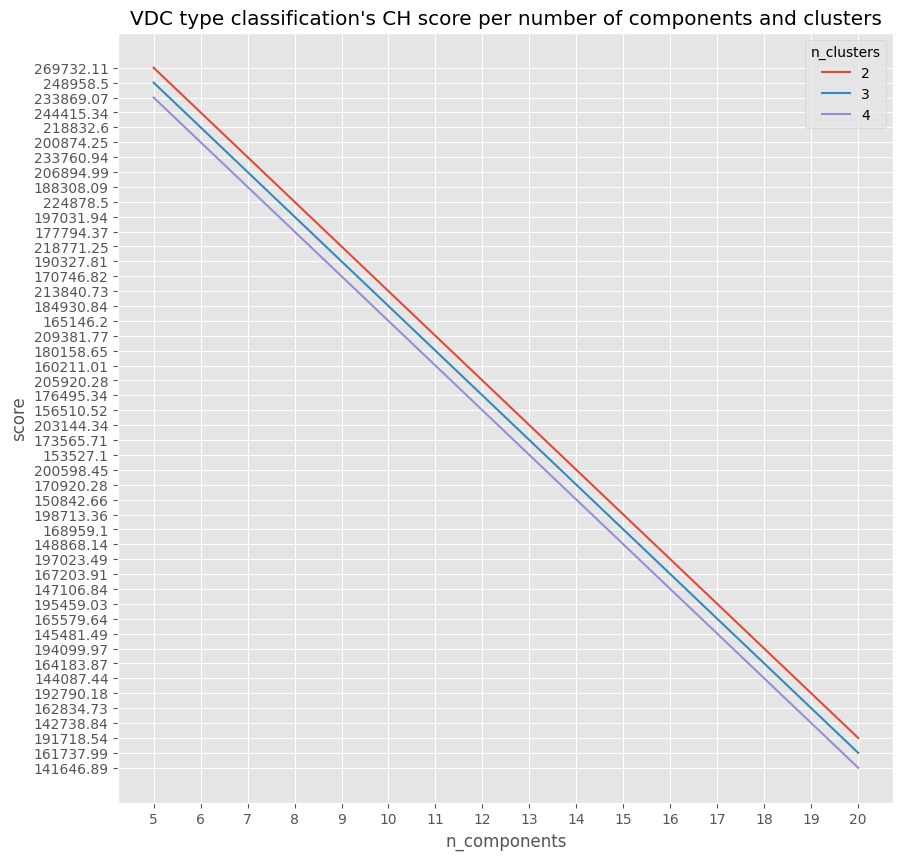

{'n_components': '5', 'n_clusters': '2', 'score': '269732.11'}

In [21]:
opt_params_grid(X_vdc_type, (5, 20), (2, 4), vdc_type_name)

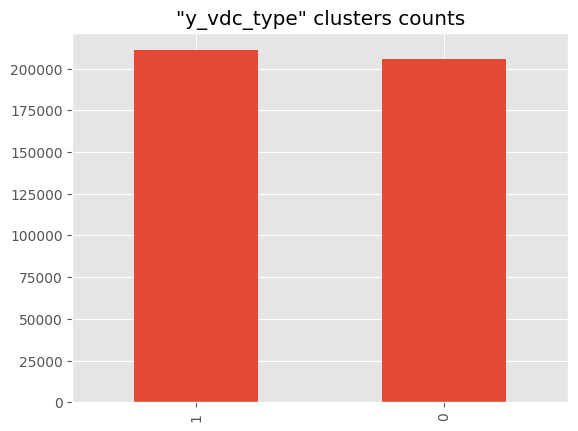

In [22]:
save_results(X_vdc_type, 'vdc_type', 5, 2)